## Import Required Libraries

In [71]:
import pandas as pd
import numpy as np
import mat73
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from pymultitaper import multitaper_spectrogram, plot_spectrogram

## Data Reading and PreProcessing

In [72]:
# Load .mat file
data = mat73.loadmat('./lfpUCLAC.mat')["lfpUCLAC"]
#data = mat73.loadmat('lfpUCLAC.mat')["lfpUCLAC"]
# Turn seizure data into a DataFrame
data = np.concatenate((data[:, :2], data[:, 11:]), axis=1)
column_names = ["Animal", "Session"]
column_names += [f"SZ_{i}" for i in range(11, 36012)]
seizure = pd.DataFrame(data, columns=column_names)
# Read Meta Data
#metadata = pd.read_csv("ADszNov7v21LeoIv2(in).csv")
metadata = pd.read_csv("./ADszNov7v21LeoIv3.csv")
# Merge two DataFrames
dataset = pd.merge(metadata, seizure, on=["Animal", "Session"], how='inner')

In [73]:
dataset

,Animal,Session,group,BaseStart,BaseEnd,NoSzstart2,NoSzend2,SzArtifactStart,SzArtifactEnd,SeizureStart,...,SZ_36002,SZ_36003,SZ_36004,SZ_36005,SZ_36006,SZ_36007,SZ_36008,SZ_36009,SZ_36010,SZ_36011
0,8790,2,1,-60.0,-20.0,6.0,120,-21.00,0,3.3,...,0.895588,0.866927,1.000345,1.083360,1.033944,0.890641,0.746350,0.860990,0.699898,0.401434
1,8799,2,1,-60.0,-11.0,30.0,120,-12.00,0,20.5,...,0.128512,0.141584,0.138678,0.087841,0.079126,0.025384,0.067505,-0.051598,0.006501,0.070409
2,12224,2,1,-60.0,-8.0,13.0,120,-7.50,0,8.5,...,0.009078,-0.023774,-0.006766,0.009076,-0.015155,-0.015389,0.014666,-0.004905,-0.014225,0.013500
3,12233,2,1,-60.0,-3.0,30.0,120,-2.00,0,10.0,...,0.001998,-0.022745,0.031218,-0.214643,0.020953,0.060175,-0.098818,0.052542,-0.026954,-0.019320
4,12234,2,1,-60.0,-2.0,39.0,120,-1.00,0,12.0,...,0.193024,-0.020621,0.196557,0.332058,0.345042,0.281896,0.317190,0.327150,0.339630,0.317448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,12233,19,1,0.0,0.0,20.0,89,0.65,0,9.2,...,0.016741,0.099218,-0.023653,0.102346,0.103549,-0.060198,0.098502,0.002803,-0.011623,0.046087
165,8793,19,2,-60.0,-37.0,28.5,120,0.00,0,2.6,...,-0.588621,-0.241770,0.429002,0.486332,0.377403,0.214010,0.007618,0.050616,-0.045414,0.133745
166,8797,19,2,-60.0,-53.0,40.0,120,0.00,0,3.3,...,0.074535,-0.049774,-0.050855,0.014002,0.137230,0.119934,0.122096,0.004272,0.018324,0.037781
167,12227,19,2,-60.0,-3.0,46.0,120,0.40,0,8.8,...,0.420122,0.379910,0.380465,0.387676,0.385735,0.359945,0.362996,0.341087,0.320843,0.318070


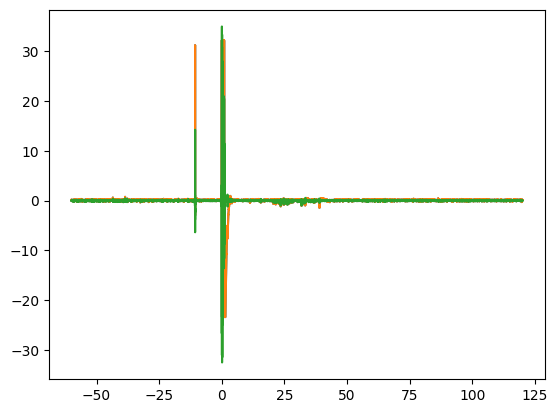

In [74]:
# Design the bandpass filter
b, a = butter(8, [4, 50], 
              btype='bandpass', fs=200)

# Apply zero-phase filtering
rawlfp = dataset.loc[:, "SZ_11":]
rawlfp = rawlfp.to_numpy()

start = -60
stop = 120

t_lfp = np.linspace(start, stop, rawlfp.shape[1]) 
t_base = np.where(t_lfp<=2)

lfp_f = rawlfp.copy()
# reduce amplitude of noise in raw lfp
# for lfp_in in range(rawlfp.shape[0]): 
#     lfp_f[lfp_in,:] = rawlfp[lfp_in,:]
#     lfp_b = lfp_f[lfp_in,t_base]
#     std_b = np.std(lfp_b)
#     mean_b = np.mean(lfp_b)
#     thresh_b = 3 * std_b
#     mask_b = np.abs(lfp_b-mean_b) <= thresh_b
#     lfp_b[~mask_b] = 0
#     lfp_f[lfp_in,t_base] = lfp_b

fast = filtfilt(b, a, lfp_f)
plt.figure()
plt.plot(t_lfp,rawlfp[1,:])
plt.plot(t_lfp,lfp_f[1,:])
plt.plot(t_lfp, fast[1,:])


In [75]:

def bandpass_filter_spectrogram(freqs, psd, low_freq, high_freq):
    """Extract only the desired frequency range from spectrogram"""
    # Find frequency indices
    freq_indices = (freqs >= low_freq) & (freqs <= high_freq)
    
    # Extract bandpass frequencies and PSD
    freqs_bp = freqs[freq_indices]
    psd_bp = psd[freq_indices,:]
    
    return freqs_bp, psd_bp


In [76]:
def zscorepsd_data(datapsd):
    datapsd = zscore(datapsd, axis=None)
    min_psd = np.min(datapsd)
    max_psd = np.max(datapsd)
    datapsd = datapsd - min_psd / (max_psd - min_psd) * 10
    return datapsd

In [77]:
# times.shape
# in_base_psd = np.where((times>= metadata.BaseStart[1]) & (times<= metadata.BaseEnd[1]))[0]
# print(len(in_base_psd))
# print(times[in_base_psd])
# print(psd_tempFilt.shape)
# print(psd_tempFilt[:, in_base_psd].shape)
# psd_base = np.mean(psd_tempFilt[:, in_base_psd], axis=1)
# print(psd_base.shape)
# print(psd_tempFilt.shape)

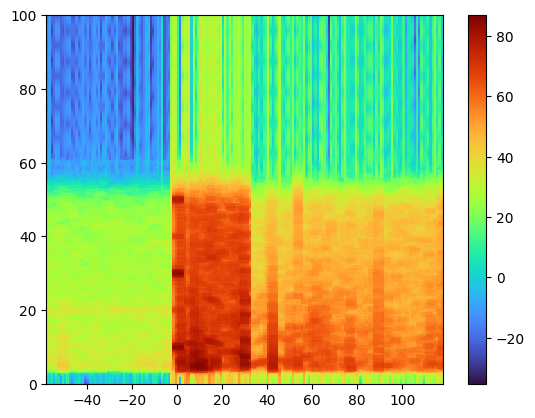

(513, 176) (513,) (176,)
(200, 176) (200,) (176,)
(176,)


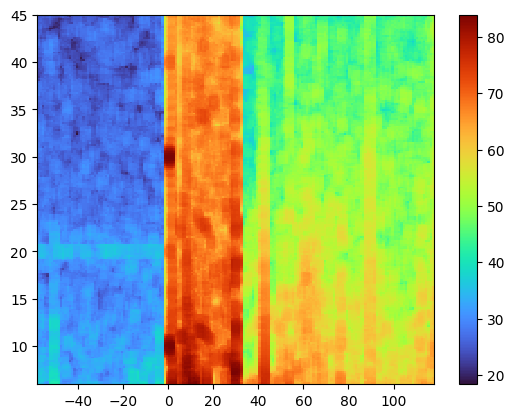

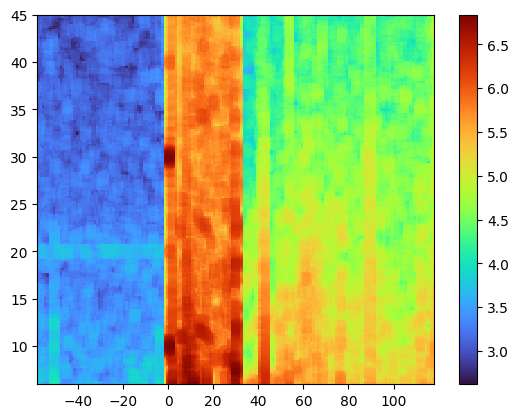

In [78]:
# Parameters for MultiTaper Spectrograms
fs = 200
psdWindowStep = 1
windowtimelength = 5
low_freq = 6   # Hz
high_freq = 45 # Hz


session_testid = 162
# Get dimensions from first row to initialize the 3D matrix
freqs, times, psd_temp = multitaper_spectrogram(fast[session_testid,:], fs, time_step=psdWindowStep, 
                                                window_length=windowtimelength, NW=4)
freq_indices = (freqs >= low_freq) & (freqs <= high_freq)
times = times - 60

plt.pcolormesh(times, freqs, psd_temp, cmap = 'turbo', shading='auto')
plt.colorbar()
plt.show()
print(psd_temp.shape, freqs.shape, times.shape)
#print(times,freqs)
freqsFilt, psd_tempFilt = bandpass_filter_spectrogram(freqs, psd_temp, low_freq, high_freq) 
print(psd_tempFilt.shape, freqsFilt.shape, times.shape)
#print(times, freqsFilt)



def base_norm_psd(psd_data, session_testid,times):
    in_base_psd = np.where((times>= metadata.BaseStart[session_testid]) & (times<= metadata.BaseEnd[session_testid]))[0]
    in_sz_psd = np.where((times>= metadata.SeizureStart[session_testid]) & (times<= metadata.SeizureEnd[session_testid]))[0]
    if len(in_sz_psd) == 0:
        psd_norm = psd_data.copy()
        print("No Seizure")
    else: 
        if len(in_base_psd) == 0:
            psd_norm = psd_data.copy()
            times_base = times.copy()
            print(times_base.shape)
        else:
            psd_norm = psd_data.copy()
            psd_base = np.mean(psd_data[:, in_base_psd], axis=1)
            # psd_norm[:, in_sz_psd] = psd_data[:, in_sz_psd] - psd_base.reshape(len(psd_base),1)
            psd_norm = psd_data - psd_base.reshape(len(psd_base),1)
            times_base = times[in_base_psd]
            print(times_base.shape)
    return psd_norm

psd_tempFilt = base_norm_psd(psd_tempFilt, session_testid=session_testid, times=times)

plt.pcolormesh(times, freqsFilt, psd_tempFilt, cmap = 'turbo', shading='auto')
plt.colorbar()
plt.show()

psd_tempFilt = zscorepsd_data(psd_tempFilt)
plt.pcolormesh(times, freqsFilt, psd_tempFilt, cmap = 'turbo', shading='auto')
plt.colorbar()
plt.show()


In [79]:
# Initialize 3D matrix: (n_sessions, n_freqs, n_times)
n_sessions = fast.shape[0]
n_freqs = len(freqsFilt)
n_times = len(times)
psd_3d = np.zeros((n_sessions, n_freqs, n_times))

print(f"Processing {n_sessions} sessions...")
print(f"PSD matrix shape will be: ({n_sessions}, {n_freqs}, {n_times})")

# Loop through all rows (sessions)
for session in range(n_sessions):
    print(f"Processing session {session + 1}/{n_sessions}")
    
    # Get spectrogram for this session
    freqs, times,  psd = multitaper_spectrogram(fast[session,:], fs, time_step=psdWindowStep, 
                                               window_length=windowtimelength, NW=4)
    times = times - 60
    # Convert to log scale
    #psd = np.interp(psd, (psd.min(), psd.max()), (0, 10))
    #psd_log = 10 * np.log10(psd)
    #psd_log = np.interp(psd_log, (psd_log.min(), psd_log.max()), (0, 10))
    
    freqs, psd = bandpass_filter_spectrogram(freqs, psd, low_freq, high_freq)
    # psd = base_norm_psd(psd, session_testid=session,times=times)
    psd = zscorepsd_data(psd)
    
    
    # Store in 3D matrix
    
    psd_3d[session, :, :] = psd

print("Done! 3D PSD matrix created.")
print(f"Final shape: {psd_3d.shape}")
print(f"Shape interpretation: (sessions={psd_3d.shape[0]}, freqs={psd_3d.shape[1]}, times={psd_3d.shape[2]})")

Processing 169 sessions...
PSD matrix shape will be: (169, 200, 176)
Processing session 1/169
Processing session 2/169
Processing session 3/169
Processing session 4/169
Processing session 5/169
Processing session 6/169
Processing session 7/169
Processing session 8/169
Processing session 9/169
Processing session 10/169
Processing session 11/169
Processing session 12/169
Processing session 13/169
Processing session 14/169
Processing session 15/169
Processing session 16/169
Processing session 17/169
Processing session 18/169
Processing session 19/169
Processing session 20/169
Processing session 21/169
Processing session 22/169
Processing session 23/169
Processing session 24/169
Processing session 25/169
Processing session 26/169
Processing session 27/169
Processing session 28/169
Processing session 29/169
Processing session 30/169
Processing session 31/169
Processing session 32/169
Processing session 33/169
Processing session 34/169
Processing session 35/169
Processing session 36/169
Proc

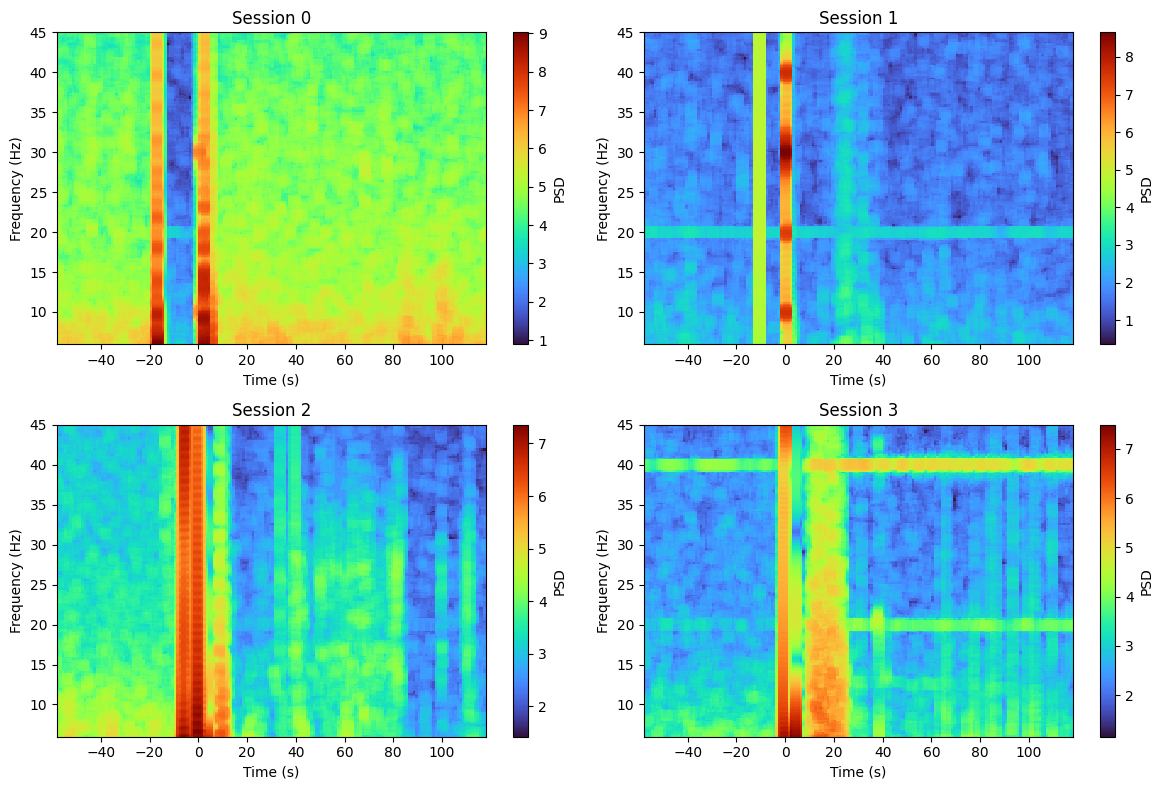

In [80]:
# Example: Plot a few channels
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(min(4, n_sessions)):  # Plot first 4 channels
    im = axes[i].pcolormesh(times, freqs, psd_3d[i], cmap = 'turbo', shading='auto')
    axes[i].set_title(f'Session {i}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Frequency (Hz)')
    plt.colorbar(im, ax=axes[i], label='PSD')

plt.tight_layout()
plt.show()


In [81]:
#times -= 60
psd_3d[2,:,:].min()
print(psd_3d.shape)

(169, 200, 176)


In [82]:
import math
def time2index(time, start, psdWindowStep):
    return math.floor((time - start) / psdWindowStep)

In [83]:
start = -60
times_to_convert = ["BaseStart", "BaseEnd","SeizureStart", "SeizureEnd", "SzArtifactStart", "SzArtifactEnd"]
for column_name in times_to_convert:
    dataset[column_name] = dataset[column_name].apply(lambda x: time2index(x, start=start, psdWindowStep=psdWindowStep))
    #dataset[column_name] = dataset[column_name].astype(int)

In [84]:
print(metadata.Animal.dtype)
print(dataset.loc[:,"Animal"].dtype)
print(psd_3d.shape)

int64
int64
(169, 200, 176)


In [85]:
def extract_samples(idx, time_row):        
    time_row = time_row.astype(int)
    base = psd_3d[idx, :, time_row["BaseStart"]: time_row["BaseEnd"]]
    seizure = psd_3d[idx, :, time_row["SeizureStart"]: time_row["SeizureEnd"]]
    artifact = psd_3d[idx, :, time_row["SzArtifactStart"]: time_row["SzArtifactEnd"]]
    return base.T, seizure.T, artifact.T

In [86]:
feature_dim = psd_3d.shape[1] 
animalID = 8790
all_base = np.empty((0, feature_dim))
all_seizure = np.empty((0, feature_dim))
all_artifact = np.empty((0, feature_dim))
# animal id = 8790, 8799, 8800, 8798, 8797, 12233, 12234, 12226, 12227, 12228, 12229, 12224

for i in range(len(dataset)):
    if dataset.loc[i,"Animal"]==animalID:
        base, seizure, artifact = extract_samples(i, dataset.loc[i, times_to_convert])
        all_base = np.concatenate((all_base, base), axis=0)
        all_seizure = np.concatenate((all_seizure, seizure), axis=0)
        all_artifact = np.concatenate((all_artifact, artifact), axis=0)

In [87]:
BASE_LABEL = 0
ARTIFACT_LABEL = 1
SEIZURE_LABEL = 2

In [88]:
base_label_arr = np.ones(shape=(len(all_base), 1)) * BASE_LABEL
artifact_label_arr = np.ones(shape=(len(all_artifact), 1)) * ARTIFACT_LABEL
seizure_label_arr = np.ones(shape=(len(all_seizure), 1)) * SEIZURE_LABEL

In [89]:
all_base = np.concatenate((all_base, base_label_arr), axis=1)
all_artifact = np.concatenate((all_artifact, artifact_label_arr), axis=1)
all_seizure = np.concatenate((all_seizure, seizure_label_arr), axis=1)

In [90]:
print(all_seizure.shape,all_base.shape)

(352, 201) (358, 201)


In [91]:
all_data = np.concatenate((all_base, all_artifact, all_seizure), axis=0)
all_data.shape

(751, 201)

In [92]:
np.random.shuffle(all_data)
all_data.shape

(751, 201)

# Modelling

## Imports

In [93]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import load_iris
import scipy
from tqdm import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import math
import copy


## Helper Functions

In [94]:
def plot_train_val_test_accuracy(train_acc, val_acc, test_acc):
  epochs = list(range(1, len(train_acc) + 1))

    # Create the figure
  fig = go.Figure()

    # Add traces
  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=train_acc,
            name="Train Accuracy",
            mode='lines',
            line=dict(color='#8b5cf6', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )

  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=val_acc,
            name="Validation Accuracyy",
            mode='lines',
            line=dict(color='#22c55e', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )

  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=test_acc,
            name="Test Accuracyy",
            mode='lines',
            line=dict(color='#800080', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )


    # Update layout
  fig.update_layout(
        title=dict(
            text="Training, Validation and Test Accuracy over Epochs",
            x=0.5,
            y=0.95,
            xanchor='center',
            yanchor='top'
        ),
        xaxis_title="Epochs",
        yaxis_title="Accuracy",
        hovermode='x unified',
        template='plotly_white',
        xaxis=dict(
            tickmode='linear',
            tick0=1,
            dtick=max(1, len(epochs) // 10)  # Show ~10 ticks on x-axis
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

  fig.show()


In [95]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [96]:
# @title Set device (GPU or CPU).
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [97]:
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.
GPU is enabled in this notebook.


## Model Definition

In [98]:
class FFN(nn.Module):

    @staticmethod
    def he_uniform_init(layer):
        """
        Apply He Uniform Initialization to the layer's weights and optionally biases
        """
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)  # common practice is to zero biases

    def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num, has_batch_norm=True):
        """
        Initialize Feed-Forward Network parameters
        """
        super(FFN, self).__init__()
        self.input_feature_num = input_feature_num
        self.ffn = nn.Sequential()
        in_num = input_feature_num

        for layer_index, out_num in enumerate(hidden_unit_nums):
            layer = nn.Linear(in_num, out_num, bias=True)
            self.he_uniform_init(layer)  # Apply He initialization here
            self.ffn.add_module(f"Linear_{layer_index}", layer)

            # Batch Normalization Layer
            if has_batch_norm:
                self.ffn.add_module(f"BatchNorm_{layer_index}", nn.BatchNorm1d(out_num))

            actv_layer = eval(f"nn.{actv}")  
            self.ffn.add_module(f"Activation_{layer_index}", actv_layer)

            in_num = out_num

        out_layer = nn.Linear(in_num, output_feature_num, bias=True)
        self.he_uniform_init(out_layer)  
        self.ffn.add_module(f'Linear_{len(hidden_unit_nums)}', out_layer)

    def forward(self, x):
        x = x.view(-1, self.input_feature_num)
        return self.ffn(x)


## Defining DataLoaders

In [99]:
X = all_data[:, :-1]  # features 
y = all_data[:, -1]   # labels  

# Split using sklearn
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=SEED)
# Convert to tensors
X_train_tensor, y_train_tensor = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)  # or float32 for regression
X_val_tensor, y_val_tensor = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
X_test_tensor, y_test_tensor = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [100]:
batch_size = 512
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

def get_data_loaders(train_dataset, val_dataset, test_dataset):

  train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )


  val_loader = DataLoader(val_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                        )

  test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                        )
  return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset)

## Training Loop

In [101]:
def get_model_accuracy(net, data_loader, device=DEVICE):
  correct = 0
  net.eval()  # Set model to evaluation mode
  with torch.no_grad():  # No need to track gradients
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      y_pred = torch.argmax(net(inputs), dim=1)
      correct += (labels == y_pred).sum().item()
  accuracy = (correct / len(data_loader.dataset)) * 100
  return accuracy


def get_loss(net, criterion, data_loader, device=DEVICE):
    net.eval() #Set model to evaluation mode
    with torch.no_grad():
        running_loss = 0.0
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(data_loader)




def train_eval_model(net, criterion, optimizer, train_loader, valid_loader, test_loader, num_epochs, validation_freq, verbose=True, device=DEVICE):
    net.to(device)
    training_accuracy, validation_accuracy, test_accuracy = [], [], []
    for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
        net.train()
        running_loss = 0.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # add current loss to running_loss
            running_loss += loss.detach().item()
        train_loss = running_loss / len(train_loader)
        if verbose:
          print(f"Epoch {epoch}: Train Loss {train_loss}")
        # save accuracy and loss for plotting
        if epoch % validation_freq == 0:
            validation_accuracy.append(get_model_accuracy(net, valid_loader))
            test_accuracy.append(get_model_accuracy(net, test_loader))
            training_accuracy.append(get_model_accuracy(net, train_loader))
    return net, training_accuracy, validation_accuracy, test_accuracy


In [102]:
actv = "ReLU()"
input_feature_num = feature_dim
hidden_unit_nums = [4096, 2048, 1024, 512, 256, 128]
output_feature_num = 3
max_epochs = 300
criterion = nn.CrossEntropyLoss()
mlp = FFN(actv, input_feature_num, hidden_unit_nums, output_feature_num)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

In [103]:
net, train_acc, valid_acc, test_acc = train_eval_model(mlp, criterion, optimizer, train_loader, val_loader, test_loader, max_epochs, validation_freq=10)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 0: Train Loss 0.8966480791568756
Epoch 1: Train Loss 0.5433626919984818
Epoch 2: Train Loss 0.21148592978715897
Epoch 3: Train Loss 0.13541750982403755
Epoch 4: Train Loss 0.10446752235293388


  2%|▏         | 6/300 [00:00<00:11, 25.60it/s]

Epoch 5: Train Loss 0.07192015834152699
Epoch 6: Train Loss 0.08204013854265213
Epoch 7: Train Loss 0.06001646816730499


  4%|▍         | 12/300 [00:00<00:07, 38.51it/s]

Epoch 8: Train Loss 0.055539850145578384
Epoch 9: Train Loss 0.04797324910759926
Epoch 10: Train Loss 0.049857741221785545
Epoch 11: Train Loss 0.046230439096689224
Epoch 12: Train Loss 0.037620093673467636
Epoch 13: Train Loss 0.0523232389241457
Epoch 14: Train Loss 0.02897168230265379
Epoch 15: Train Loss 0.08936989679932594
Epoch 16: Train Loss 0.07744359131902456
Epoch 17: Train Loss 0.02352514211088419


  6%|▋         | 19/300 [00:00<00:05, 47.84it/s]

Epoch 18: Train Loss 0.03621096909046173
Epoch 19: Train Loss 0.034887831658124924
Epoch 20: Train Loss 0.02198492083698511


  9%|▊         | 26/300 [00:00<00:05, 53.12it/s]

Epoch 21: Train Loss 0.017713519744575024
Epoch 22: Train Loss 0.018912852741777897
Epoch 23: Train Loss 0.027098178397864103
Epoch 24: Train Loss 0.023218867368996143
Epoch 25: Train Loss 0.03126982040703297
Epoch 26: Train Loss 0.020171295385807753
Epoch 27: Train Loss 0.14570480212569237
Epoch 28: Train Loss 0.07919514738023281
Epoch 29: Train Loss 0.025970958173274994
Epoch 30: Train Loss 0.033066834323108196


 11%|█         | 33/300 [00:00<00:04, 56.53it/s]

Epoch 31: Train Loss 0.02169550582766533
Epoch 32: Train Loss 0.025711785536259413
Epoch 33: Train Loss 0.01418155012652278


 13%|█▎        | 40/300 [00:00<00:04, 58.95it/s]

Epoch 34: Train Loss 0.018713832832872868
Epoch 35: Train Loss 0.013385535683482885
Epoch 36: Train Loss 0.02418370172381401
Epoch 37: Train Loss 0.019887820817530155
Epoch 38: Train Loss 0.02725565852597356
Epoch 39: Train Loss 0.03799937339499593
Epoch 40: Train Loss 0.014001305215060711
Epoch 41: Train Loss 0.027286913711577654
Epoch 42: Train Loss 0.008688765345141292
Epoch 43: Train Loss 0.02580447681248188


 16%|█▌        | 47/300 [00:00<00:04, 60.37it/s]

Epoch 44: Train Loss 0.01283960323780775
Epoch 45: Train Loss 0.0183888201136142
Epoch 46: Train Loss 0.012425289954990149


 18%|█▊        | 54/300 [00:00<00:04, 61.06it/s]

Epoch 47: Train Loss 0.025081072933971882
Epoch 48: Train Loss 0.014255293179303408
Epoch 49: Train Loss 0.008410691982135177
Epoch 50: Train Loss 0.006269187433645129
Epoch 51: Train Loss 0.020639845519326627
Epoch 52: Train Loss 0.039663245202973485
Epoch 53: Train Loss 0.013434106484055519
Epoch 54: Train Loss 0.018968296237289906
Epoch 55: Train Loss 0.01838807761669159
Epoch 56: Train Loss 0.015273797791451216
Epoch 57: Train Loss 0.011893983231857419
Epoch 58: Train Loss 0.01876953849568963
Epoch 59: Train Loss 0.03249903954565525


 23%|██▎       | 68/300 [00:01<00:03, 62.47it/s]

Epoch 60: Train Loss 0.01465059444308281
Epoch 61: Train Loss 0.027143461629748344
Epoch 62: Train Loss 0.028417158406227827
Epoch 63: Train Loss 0.007609495427459478
Epoch 64: Train Loss 0.025477726012468338
Epoch 65: Train Loss 0.033430326730012894
Epoch 66: Train Loss 0.0072843339294195175
Epoch 67: Train Loss 0.034839678555727005
Epoch 68: Train Loss 0.015710766427218914
Epoch 69: Train Loss 0.025321409571915865
Epoch 70: Train Loss 0.02669299370609224
Epoch 71: Train Loss 0.025079294107854366
Epoch 72: Train Loss 0.019866143818944693


 27%|██▋       | 82/300 [00:01<00:03, 62.37it/s]

Epoch 73: Train Loss 0.01798432762734592
Epoch 74: Train Loss 0.021833214908838272
Epoch 75: Train Loss 0.01612626714631915
Epoch 76: Train Loss 0.012632124125957489
Epoch 77: Train Loss 0.020967592485249043
Epoch 78: Train Loss 0.006210090359672904
Epoch 79: Train Loss 0.006925679976120591
Epoch 80: Train Loss 0.008580719120800495
Epoch 81: Train Loss 0.008261458948254585
Epoch 82: Train Loss 0.005004480131901801
Epoch 83: Train Loss 0.008143357001245022
Epoch 84: Train Loss 0.004543034243397415
Epoch 85: Train Loss 0.0064866498578339815


 32%|███▏      | 96/300 [00:01<00:03, 63.20it/s]

Epoch 86: Train Loss 0.049520771834068
Epoch 87: Train Loss 0.008429164765402675
Epoch 88: Train Loss 0.00888941332232207
Epoch 89: Train Loss 0.011097217444330454
Epoch 90: Train Loss 0.0075663793832063675
Epoch 91: Train Loss 0.004081445164047182
Epoch 92: Train Loss 0.004847109084948897
Epoch 93: Train Loss 0.012193709029816091
Epoch 94: Train Loss 0.0043700182577595115
Epoch 95: Train Loss 0.011119699105620384
Epoch 96: Train Loss 0.004036626196466386
Epoch 97: Train Loss 0.0043443720787763596
Epoch 98: Train Loss 0.02235193515662104


 34%|███▍      | 103/300 [00:01<00:03, 62.76it/s]

Epoch 99: Train Loss 0.004059026949107647
Epoch 100: Train Loss 0.004310451913625002
Epoch 101: Train Loss 0.005359930626582354
Epoch 102: Train Loss 0.00783456931822002
Epoch 103: Train Loss 0.004278358072042465
Epoch 104: Train Loss 0.0035216616233810782
Epoch 105: Train Loss 0.004414867726154625
Epoch 106: Train Loss 0.01630019093863666
Epoch 107: Train Loss 0.005898476578295231
Epoch 108: Train Loss 0.01415019336855039


 37%|███▋      | 110/300 [00:01<00:02, 64.06it/s]

Epoch 109: Train Loss 0.004303892143070698
Epoch 110: Train Loss 0.006983523722738028
Epoch 111: Train Loss 0.010531414533033967


 39%|███▉      | 117/300 [00:01<00:02, 63.72it/s]

Epoch 112: Train Loss 0.004143998143263161
Epoch 113: Train Loss 0.013005605898797512
Epoch 114: Train Loss 0.011748987599276006
Epoch 115: Train Loss 0.011858633370138705
Epoch 116: Train Loss 0.0035472019226290286
Epoch 117: Train Loss 0.004138253454584628
Epoch 118: Train Loss 0.004394050018163398
Epoch 119: Train Loss 0.004330685187596828
Epoch 120: Train Loss 0.012768445536494255
Epoch 121: Train Loss 0.0034786234609782696


 41%|████▏     | 124/300 [00:02<00:02, 63.48it/s]

Epoch 122: Train Loss 0.004291492747142911
Epoch 123: Train Loss 0.04316649213433266
Epoch 124: Train Loss 0.0038331897230818868


 44%|████▎     | 131/300 [00:02<00:02, 62.94it/s]

Epoch 125: Train Loss 0.2862044498324394
Epoch 126: Train Loss 0.12141082808375359
Epoch 127: Train Loss 0.055280836299061775
Epoch 128: Train Loss 0.032138355541974306
Epoch 129: Train Loss 0.02345030102878809
Epoch 130: Train Loss 0.06057465169578791
Epoch 131: Train Loss 0.05479835718870163
Epoch 132: Train Loss 0.10590983368456364
Epoch 133: Train Loss 0.08775279857218266
Epoch 134: Train Loss 0.055250516161322594


 46%|████▌     | 138/300 [00:02<00:02, 63.90it/s]

Epoch 135: Train Loss 0.027347484603524208
Epoch 136: Train Loss 0.04478609189391136
Epoch 137: Train Loss 0.03795625455677509


 48%|████▊     | 145/300 [00:02<00:02, 63.67it/s]

Epoch 138: Train Loss 0.07155721541494131
Epoch 139: Train Loss 0.094524210318923
Epoch 140: Train Loss 0.01091723795980215
Epoch 141: Train Loss 0.0131665775552392
Epoch 142: Train Loss 0.016734739765524864
Epoch 143: Train Loss 0.02636402752250433
Epoch 144: Train Loss 0.010399834718555212
Epoch 145: Train Loss 0.049074862617999315
Epoch 146: Train Loss 0.013369123684242368
Epoch 147: Train Loss 0.055387943983078
Epoch 148: Train Loss 0.007853979943320155
Epoch 149: Train Loss 0.013882105238735676
Epoch 150: Train Loss 0.00834918487817049


 53%|█████▎    | 159/300 [00:02<00:02, 64.07it/s]

Epoch 151: Train Loss 0.029631396988406777
Epoch 152: Train Loss 0.08624624146614224
Epoch 153: Train Loss 0.019506512442603707
Epoch 154: Train Loss 0.016840300988405943
Epoch 155: Train Loss 0.01584762427955866
Epoch 156: Train Loss 0.025431177578866482
Epoch 157: Train Loss 0.016394759761169553
Epoch 158: Train Loss 0.014918509870767593
Epoch 159: Train Loss 0.029819770716130733
Epoch 160: Train Loss 0.017082294914871454
Epoch 161: Train Loss 0.012903724098578095
Epoch 162: Train Loss 0.01438132906332612
Epoch 163: Train Loss 0.006290893768891692


 58%|█████▊    | 173/300 [00:02<00:02, 63.30it/s]

Epoch 164: Train Loss 0.015494385734200478
Epoch 165: Train Loss 0.015710593666881323
Epoch 166: Train Loss 0.00537425500806421
Epoch 167: Train Loss 0.016007393831387162
Epoch 168: Train Loss 0.01830995990894735
Epoch 169: Train Loss 0.011358884628862143
Epoch 170: Train Loss 0.0047016695607453585
Epoch 171: Train Loss 0.005501948529854417
Epoch 172: Train Loss 0.010235150344669819
Epoch 173: Train Loss 0.01639690063893795
Epoch 174: Train Loss 0.11064303037710488
Epoch 175: Train Loss 0.004898999584838748
Epoch 176: Train Loss 0.014163791202008724


 62%|██████▏   | 187/300 [00:03<00:01, 63.72it/s]

Epoch 177: Train Loss 0.020444072782993317
Epoch 178: Train Loss 0.01208083750680089
Epoch 179: Train Loss 0.005420712288469076
Epoch 180: Train Loss 0.008426851592957973
Epoch 181: Train Loss 0.005036416812799871
Epoch 182: Train Loss 0.005485319532454014
Epoch 183: Train Loss 0.013884299667552114
Epoch 184: Train Loss 0.00843211985193193
Epoch 185: Train Loss 0.009008376859128475
Epoch 186: Train Loss 0.008197234012186527
Epoch 187: Train Loss 0.006862628215458244
Epoch 188: Train Loss 0.019824573304504156
Epoch 189: Train Loss 0.005234622280113399


 65%|██████▍   | 194/300 [00:03<00:01, 63.53it/s]

Epoch 190: Train Loss 0.02141545433551073
Epoch 191: Train Loss 0.03225443861447275
Epoch 192: Train Loss 0.042754256166517735
Epoch 193: Train Loss 0.005178388440981507
Epoch 194: Train Loss 0.012440911959856749
Epoch 195: Train Loss 0.016042614355683327
Epoch 196: Train Loss 0.0074142273515462875
Epoch 197: Train Loss 0.007071932312101126
Epoch 198: Train Loss 0.010019504465162754
Epoch 199: Train Loss 0.008799004834145308


 67%|██████▋   | 201/300 [00:03<00:01, 63.25it/s]

Epoch 200: Train Loss 0.003340774856042117
Epoch 201: Train Loss 0.014752203307580203
Epoch 202: Train Loss 0.00373081280849874


 69%|██████▉   | 208/300 [00:03<00:01, 64.26it/s]

Epoch 203: Train Loss 0.014715662808157504
Epoch 204: Train Loss 0.008760785916820168
Epoch 205: Train Loss 0.0033511111396364868
Epoch 206: Train Loss 0.01037014799658209
Epoch 207: Train Loss 0.004291872261092067
Epoch 208: Train Loss 0.0069094314239919186
Epoch 209: Train Loss 0.009694835403934121
Epoch 210: Train Loss 0.009222573600709438
Epoch 211: Train Loss 0.009668275015428662
Epoch 212: Train Loss 0.011457339744083583


 72%|███████▏  | 215/300 [00:03<00:01, 63.50it/s]

Epoch 213: Train Loss 0.0038981008110567927
Epoch 214: Train Loss 0.006387878675013781
Epoch 215: Train Loss 0.03024341375567019


 74%|███████▍  | 222/300 [00:03<00:01, 63.10it/s]

Epoch 216: Train Loss 0.004320097272284329
Epoch 217: Train Loss 0.03830250073224306
Epoch 218: Train Loss 0.006710706395097077
Epoch 219: Train Loss 0.018095350824296474
Epoch 220: Train Loss 0.012650024145841599
Epoch 221: Train Loss 0.037505488842725754
Epoch 222: Train Loss 0.030194980092346668
Epoch 223: Train Loss 0.031223364174365997
Epoch 224: Train Loss 0.06013312470167875
Epoch 225: Train Loss 0.018083122093230486


 76%|███████▋  | 229/300 [00:03<00:01, 63.98it/s]

Epoch 226: Train Loss 0.06118098832666874
Epoch 227: Train Loss 0.07507834583520889
Epoch 228: Train Loss 0.013113437220454216


 79%|███████▊  | 236/300 [00:03<00:01, 63.15it/s]

Epoch 229: Train Loss 0.02253769990056753
Epoch 230: Train Loss 0.02532918658107519
Epoch 231: Train Loss 0.012905105482786894
Epoch 232: Train Loss 0.010103245731443167
Epoch 233: Train Loss 0.013624086510390043
Epoch 234: Train Loss 0.02584746922366321
Epoch 235: Train Loss 0.004422352532856166
Epoch 236: Train Loss 0.02111933659762144
Epoch 237: Train Loss 0.019583631306886673
Epoch 238: Train Loss 0.005394910112954676
Epoch 239: Train Loss 0.006084329215809703
Epoch 240: Train Loss 0.007404485193546861
Epoch 241: Train Loss 0.00722352066077292


 83%|████████▎ | 250/300 [00:04<00:00, 63.75it/s]

Epoch 242: Train Loss 0.007154730847105384
Epoch 243: Train Loss 0.005578546319156885
Epoch 244: Train Loss 0.0049513435224071145
Epoch 245: Train Loss 0.004684833576902747
Epoch 246: Train Loss 0.004320872016251087
Epoch 247: Train Loss 0.009446606389246881
Epoch 248: Train Loss 0.017053750343620777
Epoch 249: Train Loss 0.004355226818006486
Epoch 250: Train Loss 0.007600999902933836
Epoch 251: Train Loss 0.006722598918713629
Epoch 252: Train Loss 0.010920402593910694
Epoch 253: Train Loss 0.00447608417016454
Epoch 254: Train Loss 0.005537564400583506


 88%|████████▊ | 264/300 [00:04<00:00, 63.08it/s]

Epoch 255: Train Loss 0.023523697163909674
Epoch 256: Train Loss 0.01959520881064236
Epoch 257: Train Loss 0.006334216624964029
Epoch 258: Train Loss 0.003936068736948073
Epoch 259: Train Loss 0.0053756157867610455
Epoch 260: Train Loss 0.007640011375769973
Epoch 261: Train Loss 0.014459309400990605
Epoch 262: Train Loss 0.0038201252464205027
Epoch 263: Train Loss 0.008152649272233248
Epoch 264: Train Loss 0.00420105445664376
Epoch 265: Train Loss 0.00947377155534923
Epoch 266: Train Loss 0.005978173721814528
Epoch 267: Train Loss 0.007789823692291975


 93%|█████████▎| 278/300 [00:04<00:00, 63.96it/s]

Epoch 268: Train Loss 0.07813383033499122
Epoch 269: Train Loss 0.015414298744872212
Epoch 270: Train Loss 0.013406089041382074
Epoch 271: Train Loss 0.07316680997610092
Epoch 272: Train Loss 0.015310816466808319
Epoch 273: Train Loss 0.05080542527139187
Epoch 274: Train Loss 0.01673624839168042
Epoch 275: Train Loss 0.025827365927398205
Epoch 276: Train Loss 0.006934507051482797
Epoch 277: Train Loss 0.012752653565257788
Epoch 278: Train Loss 0.014653535559773445
Epoch 279: Train Loss 0.020251089707016945
Epoch 280: Train Loss 0.024473636876791716


 95%|█████████▌| 285/300 [00:04<00:00, 63.67it/s]

Epoch 281: Train Loss 0.013742394279688597
Epoch 282: Train Loss 0.01002171402797103
Epoch 283: Train Loss 0.010374339995905757
Epoch 284: Train Loss 0.017043234314769506
Epoch 285: Train Loss 0.01170077407732606
Epoch 286: Train Loss 0.026053388137370348
Epoch 287: Train Loss 0.006721067009493709
Epoch 288: Train Loss 0.01029207743704319
Epoch 289: Train Loss 0.005487036309204996
Epoch 290: Train Loss 0.3325092541053891


 97%|█████████▋| 292/300 [00:04<00:00, 63.31it/s]

Epoch 291: Train Loss 0.003656563611002639
Epoch 292: Train Loss 0.009011487476527691
Epoch 293: Train Loss 0.03771635005250573


100%|██████████| 300/300 [00:04<00:00, 61.63it/s]

Epoch 294: Train Loss 0.047607339452952147
Epoch 295: Train Loss 0.04448564723134041
Epoch 296: Train Loss 0.06842163065448403
Epoch 297: Train Loss 0.009341375902295113
Epoch 298: Train Loss 0.014716741628944874
Epoch 299: Train Loss 0.023268590681254864


In [104]:
plot_train_val_test_accuracy(train_acc, valid_acc, test_acc)


In [105]:
psd_3d.shape

(169, 200, 176)

In [106]:
def get_labels(net, sessionID):
    net.eval()
    session = torch.tensor(psd_3d[sessionID,:,:], device=DEVICE, dtype=torch.float32).T
    real_out = np.zeros((psd_3d.shape[2],3))
    with torch.no_grad():
        trial_out = net(session)
        trial_label = torch.argmax(trial_out,dim=1)
        print(trial_label.cpu().numpy().shape)
        real_out[np.arange(psd_3d.shape[2]), trial_label.cpu().numpy()] = 1

        
    return real_out
            

In [107]:
print(all_data[:,:-1].shape, all_data.dtype, all_data[:,-1])
all_dat = torch.tensor(all_data[:,:-1], device=DEVICE, dtype=torch.float32)
y_pred = net(all_dat)
y_pred = torch.argmax(y_pred,dim=1)

y_pred = y_pred.cpu().numpy()
print(y_pred.shape)
y_real = all_data[:,-1]
print(y_real.shape)

# y_base, y_seizure, y_artifact = extract_samples(21, dataset.loc[21, times_to_convert])
# print(y_base.shape, y_seizure.shape, y_pred.shape)

(751, 200) float64 [2. 0. 0. 0. 0. 2. 0. 0. 2. 2. 0. 0. 0. 2. 0. 0. 0. 0. 1. 2. 2. 2. 2. 0.
 0. 2. 0. 0. 0. 0. 0. 2. 2. 0. 1. 0. 0. 2. 0. 2. 0. 2. 0. 0. 2. 2. 2. 2.
 1. 2. 0. 2. 1. 0. 2. 0. 2. 0. 2. 0. 0. 0. 2. 2. 0. 0. 0. 0. 2. 2. 2. 2.
 0. 2. 2. 2. 2. 0. 0. 1. 0. 0. 2. 2. 0. 0. 2. 2. 2. 0. 2. 0. 2. 2. 0. 0.
 2. 0. 0. 0. 0. 2. 0. 2. 0. 0. 2. 2. 2. 0. 2. 2. 0. 2. 2. 2. 2. 0. 2. 0.
 2. 0. 2. 0. 2. 0. 0. 2. 0. 2. 0. 0. 0. 0. 2. 1. 0. 0. 0. 2. 1. 0. 2. 2.
 0. 2. 0. 1. 2. 0. 2. 0. 0. 0. 2. 0. 0. 2. 0. 2. 0. 2. 2. 2. 0. 2. 0. 2.
 0. 0. 0. 0. 0. 2. 0. 0. 2. 2. 0. 0. 2. 0. 0. 2. 0. 2. 1. 0. 2. 2. 2. 0.
 2. 0. 0. 0. 2. 2. 2. 2. 1. 2. 0. 2. 2. 0. 2. 0. 0. 2. 0. 0. 2. 2. 0. 2.
 0. 0. 0. 2. 0. 2. 0. 2. 0. 1. 2. 0. 2. 0. 1. 2. 0. 2. 0. 0. 2. 1. 0. 2.
 2. 2. 0. 0. 2. 0. 0. 2. 0. 0. 0. 2. 0. 0. 2. 0. 2. 0. 0. 2. 2. 2. 2. 2.
 0. 0. 0. 0. 2. 2. 2. 0. 2. 2. 0. 2. 2. 0. 0. 2. 0. 2. 0. 2. 0. 0. 2. 1.
 0. 2. 0. 0. 0. 0. 2. 2. 2. 1. 2. 0. 2. 0. 2. 1. 2. 0. 0. 2. 2. 0. 0. 1.
 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 2

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_real, y_pred)
print(cm.shape, cm)
def calculate_metrics_from_cm(cm):
    """Calculate sensitivity and specificity from confusion matrix"""
    
    # For binary classification
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"Binary Classification Metrics:")
        print(f"Sensitivity (Recall): {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        
        return sensitivity, specificity
    
    # For multi-class classification
    else:
        n_classes = cm.shape[0]
        sensitivities = []
        specificities = []
        
        print(f"Multi-class Classification Metrics:")
        for i in range(n_classes):
            # True positives for class i
            tp = cm[i, i]
            
            # False negatives for class i (sum of row i, minus tp)
            fn = np.sum(cm[i, :]) - tp
            
            # False positives for class i (sum of column i, minus tp)
            fp = np.sum(cm[:, i]) - tp
            
            # True negatives for class i (all other elements)
            tn = np.sum(cm) - tp - fn - fp
            
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            sensitivities.append(sensitivity)
            specificities.append(specificity)
            
            print(f"Class {i} - Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        
        return sensitivities, specificities


(3, 3) [[356   1   1]
 [  0  41   0]
 [  1   0 351]]


Multi-class Classification Metrics:
Class 0 - Sensitivity: 0.9944, Specificity: 0.9975
Class 1 - Sensitivity: 1.0000, Specificity: 0.9986
Class 2 - Sensitivity: 0.9972, Specificity: 0.9975
[np.float64(0.994413407821229), np.float64(1.0), np.float64(0.9971590909090909)] [np.float64(0.9974554707379135), np.float64(0.9985915492957746), np.float64(0.9974937343358395)]


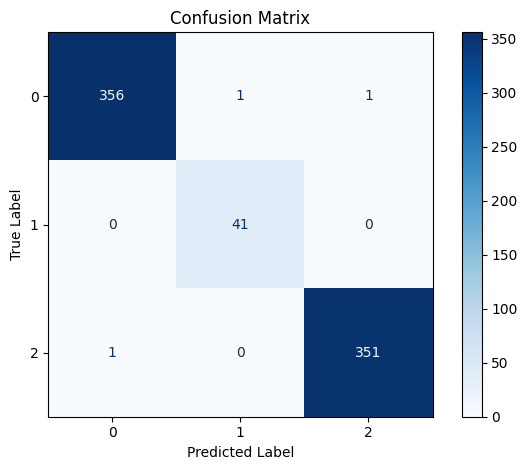

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_real, y_pred)
sensitivity, specificity = calculate_metrics_from_cm(cm)
print(sensitivity, specificity)
# Plot with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [110]:
print(all_seizure.shape[0], all_base.shape[0], all_artifact.shape[0])
#fast.shape

#print(time_lfp.shape)
#trial_lfp_label = np.zeros((time_lfp.shape[0],3))
#print(trial_lfp_label.shape)

352 358 41


In [111]:
def resample_multicolumn(t_old, data_old, fs_new, method='linear'):
    """
    Resample multi-column data to new sampling frequency
    
    Parameters:
    t_old: original time vector
    data_old: 2D array (n_samples, n_columns)  
    fs_new: new sampling frequency (Hz)
    method: interpolation method
    
    Returns:
    t_new, data_new: new time vector and resampled data
    """
    # Create new time vector
    duration = t_old[-1] - t_old[0]
    t_new = np.linspace(t_old[0], t_old[-1], int(duration * fs_new) + 1)
    
    # Interpolate all columns
    data_new = np.zeros((len(t_new), data_old.shape[1]))
    
    for col in range(data_old.shape[1]):
        f_interp = interpolate.interp1d(t_old, data_old[:, col], kind=method)
        data_new[:, col] = f_interp(t_new)
    
    return t_new, data_new


In [112]:
sessionid = dataset.loc[:,"Animal"]==animalID
sessiontest = np.where(sessionid)[0]
print(metadata.Session[sessiontest])

0       2
11      3
19      4
29      5
39      6
49      7
58      8
71      9
77     10
86     11
97     12
109    14
118    15
128    16
139    17
150    18
160    19
Name: Session, dtype: int64


(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0

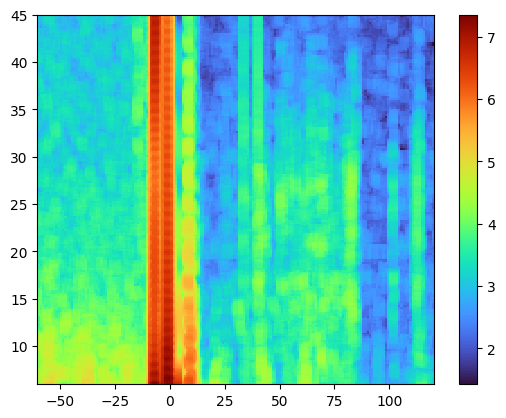

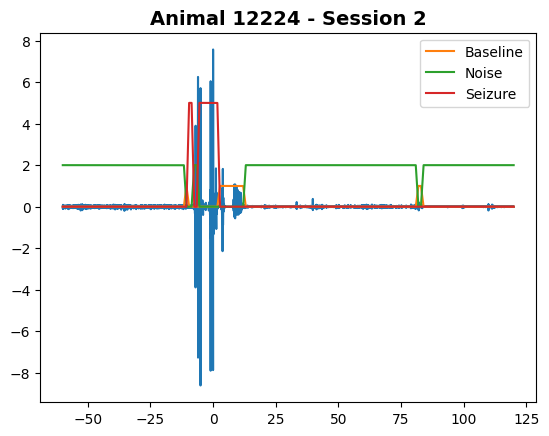

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0

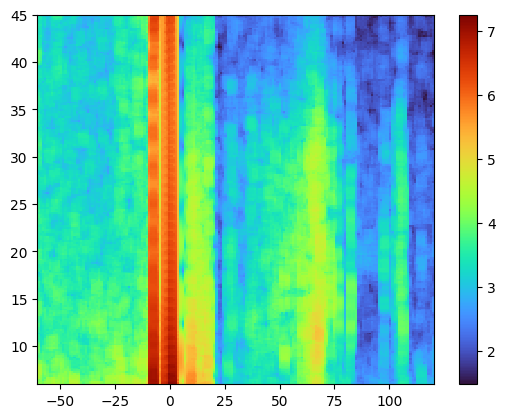

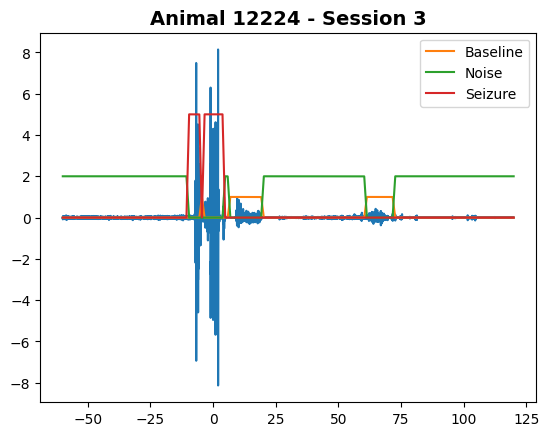

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0

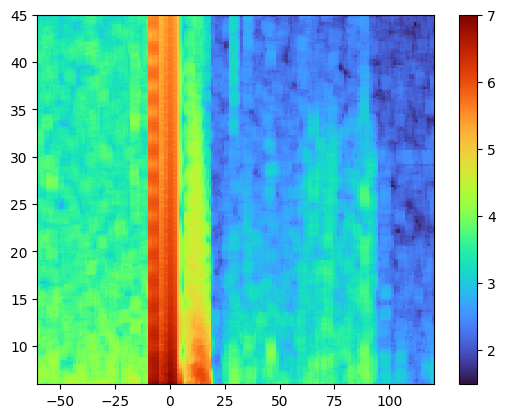

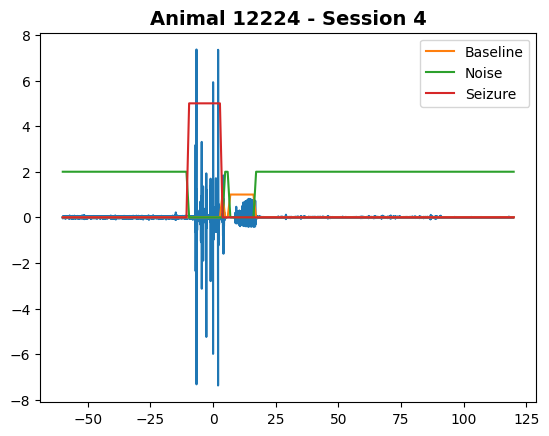

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0

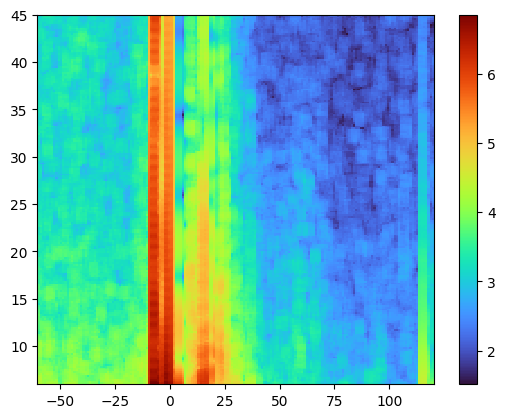

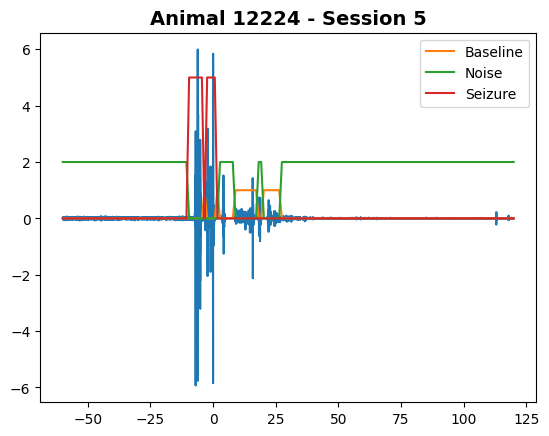

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0

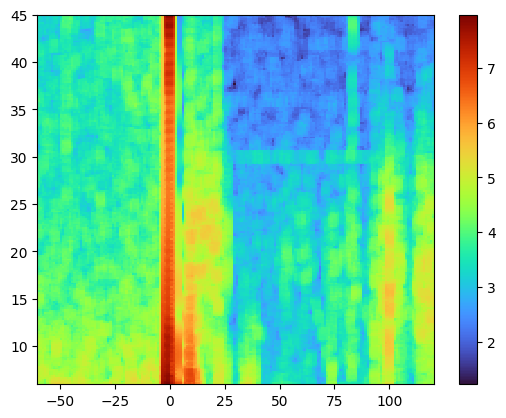

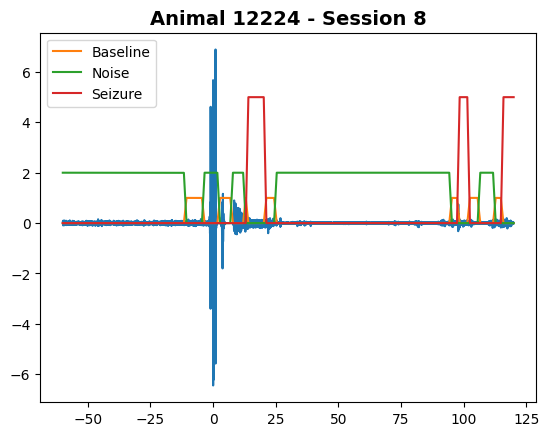

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0

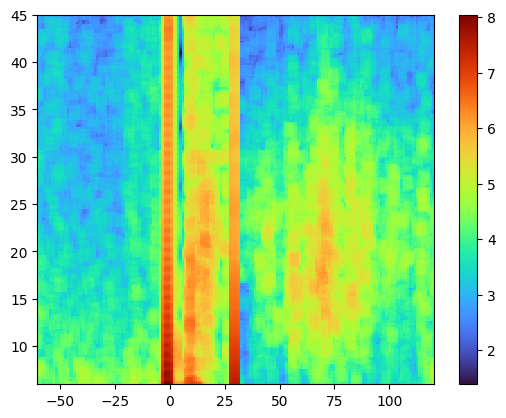

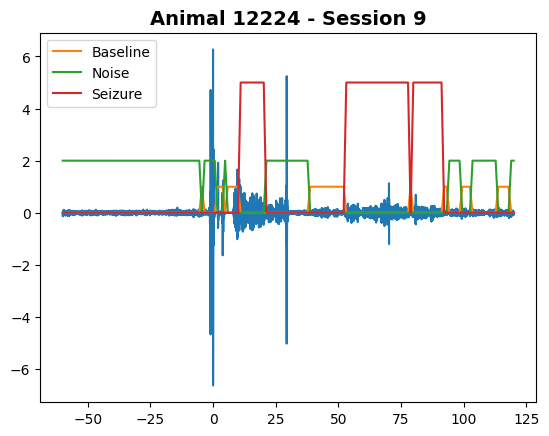

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1

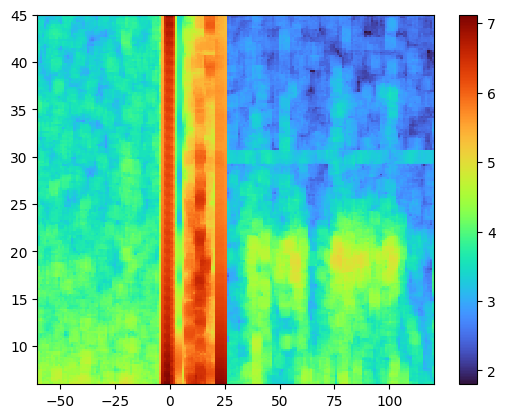

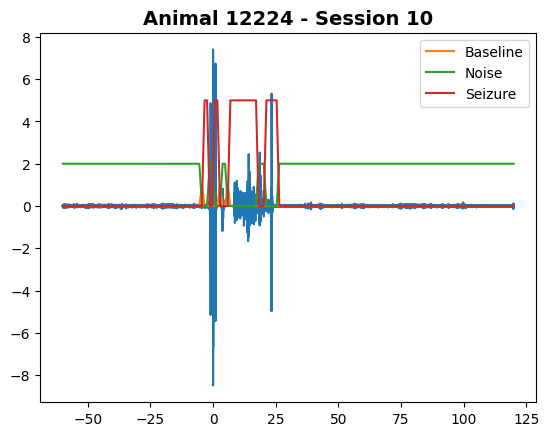

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0

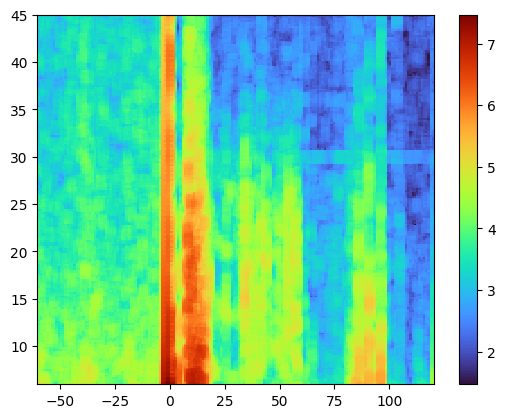

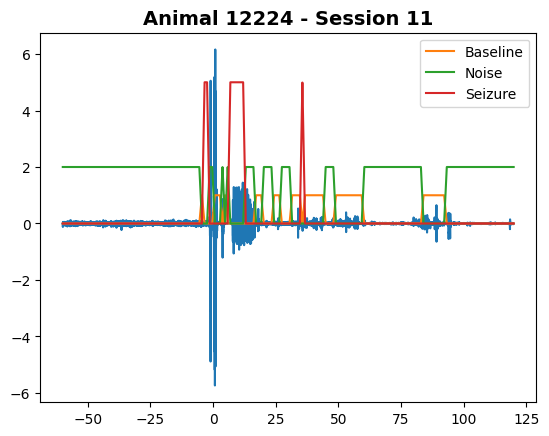

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0

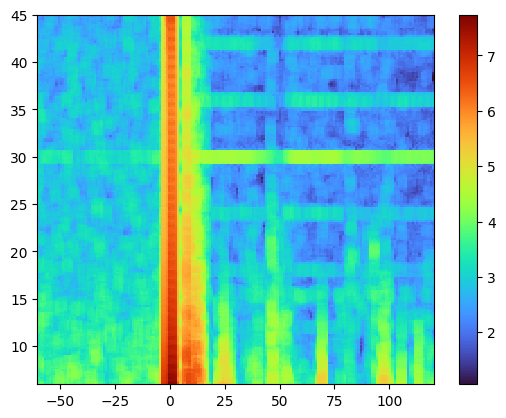

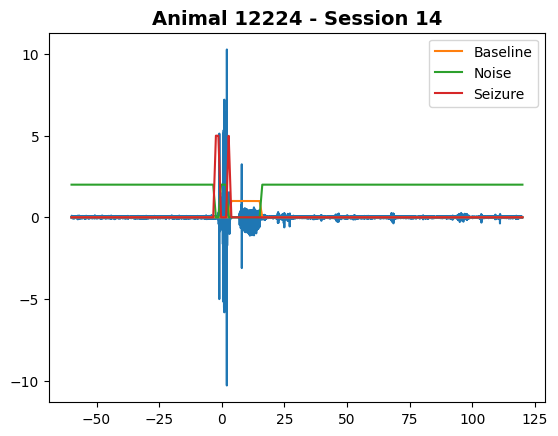

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0

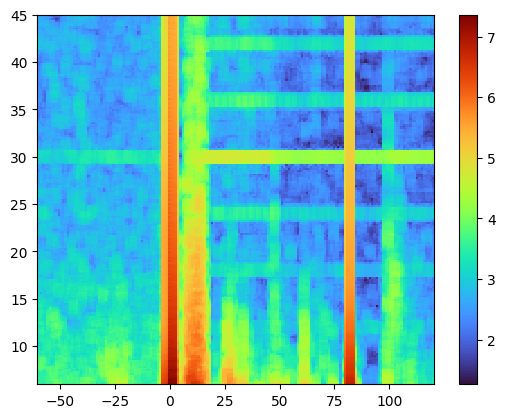

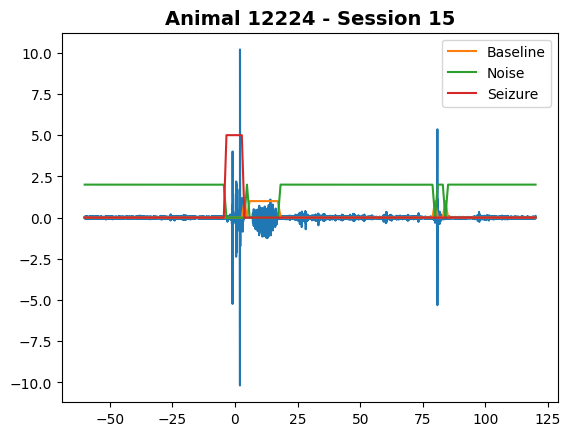

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0

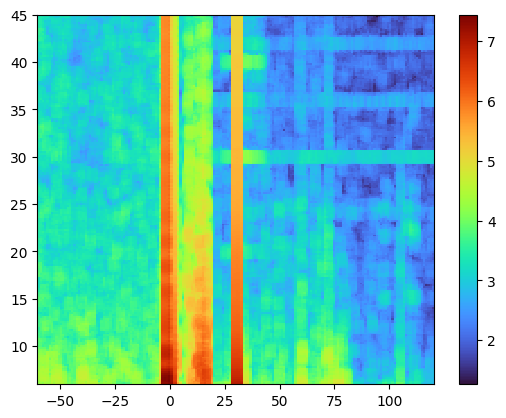

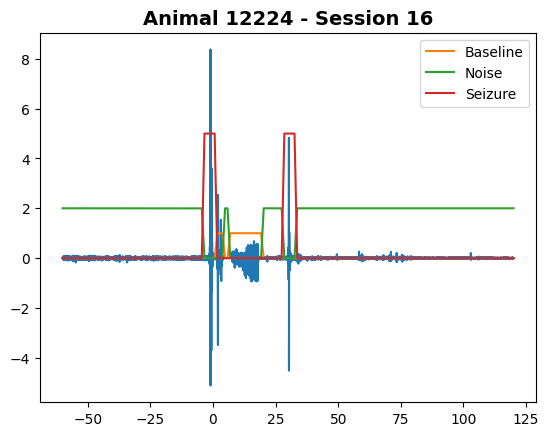

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0

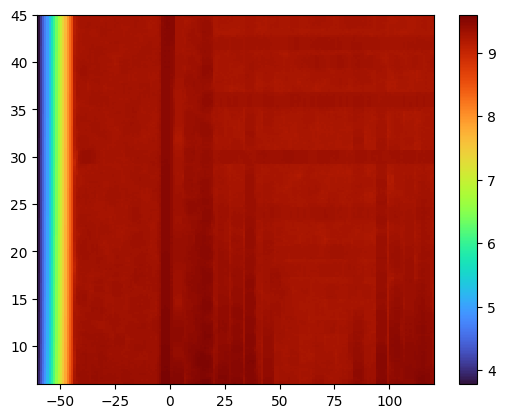

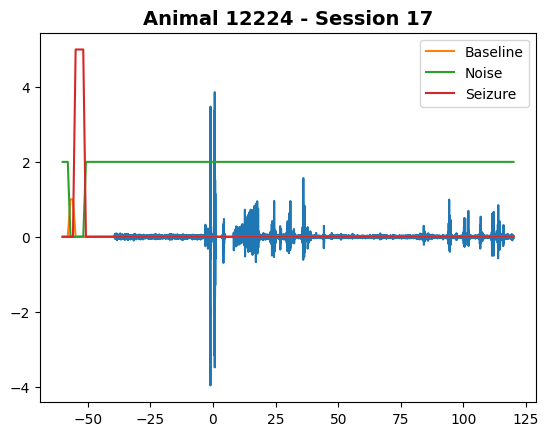

(176,)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0

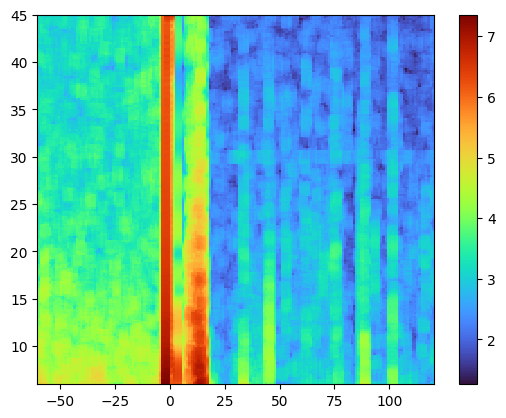

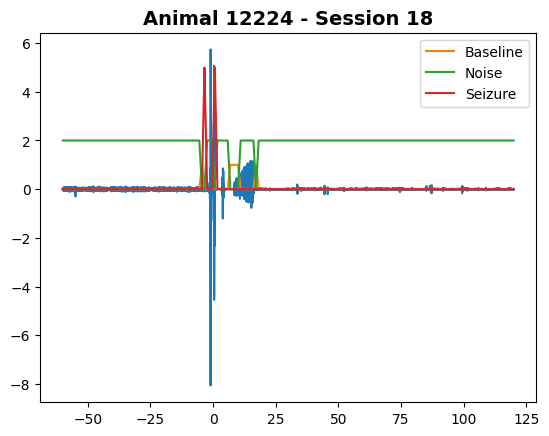

In [122]:
import os
from pathlib import Path
from scipy import interpolate
#sessiontest = [20, 21, 22, 23, 24, 31, 46, 51, 55, 89, 150, 148, 110, 112, 114, 117, 120]
animalID = 12224
sessionid = dataset.loc[:,"Animal"]==animalID
sessiontest = np.where(sessionid)[0]
output_dir = Path("animal_plots_Seizure")
output_dir.mkdir(exist_ok=True)
#essiontest = [117, 118, 120, 122, 123]
start = -60
stop = 120
times = np.linspace(start, stop, len(times))
for s_in in sessiontest:
    
    sample = torch.tensor(psd_3d[s_in,:,1], device=DEVICE, dtype=torch.float32).reshape(1, -1)
    sample.shape
    out_trial_label = get_labels(net,s_in)
    print(out_trial_label)
    animal_label = str(int(animalID))
    session_label = str(int(metadata.Session[s_in]))
    title = f"Animal {animal_label} - Session {session_label}"
    filename = f"animal_{animal_label}_session_{session_label}_spectrogram.png"
    
    plt.figure()
    plt.pcolormesh(times, freqs, psd_3d[s_in,:,:].reshape(len(freqs), len(times),), cmap = 'turbo', shading='auto')
    plt.colorbar()
    



    filepath = output_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    time_lfp = np.linspace(-60, 120, fast.shape[1])
    trial_lfp_label = np.zeros((time_lfp.shape[0],3))
    times_lfp, trial_lfp_label = resample_multicolumn(times, out_trial_label, 200, method='linear')
    plt.figure()
    plt.plot(times_lfp,fast[s_in,:])
    plt.plot(times_lfp,trial_lfp_label[:,0], label=f'Baseline')
    plt.plot(times_lfp,trial_lfp_label[:,1]*2, label=f'Noise')
    plt.plot(times_lfp,trial_lfp_label[:,2]*5, label=f'Seizure')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    
    filename = f"animal_{animal_label}_session_{session_label}.png"
    filepath = output_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [114]:
print(sessiontest.shape)
print(low_freq)

(14,)
6


In [115]:

print(metadata.Animal[117], metadata.Session[117])


12226 14


In [116]:
import sys
print(sys.prefix)

/mnt/hdd/Workspace/MyThesisRecording/LeoFilestoRun/szenv
